In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from dotenv import load_dotenv
from pandas.plotting import parallel_coordinates
import plotly.express as px

import os
import glob
import pandas as pd
import json

from utils.db_tools import get_db, filter_df, make_animation, get_data, metrics_grid, plot_grid
from classify import classify_trajectories

In [2]:
model = "bruss"
run_id = "abd_big"
load_dotenv()
data_dir = os.getenv("DATA_DIR")
output_dir = os.getenv("OUT_DIR")
df = pd.read_csv(f"{output_dir}/{model}/{run_id}/classif_metrics.csv")
df = classify_trajectories(df, steady_threshold=1, osc_threshold=1.28, dev_threshold=1.28)
df.value_counts("category")

category
I     2490
SS    1110
Name: count, dtype: int64

In [3]:
grouped = df.groupby(['A', 'B', 'Du', 'Dv'])['category']

def classify_category(group):
    unique_categories = group.unique()
    if len(unique_categories) == 1:
        return unique_categories[0]
    else:
        return 'varying'

# Apply classification
category_mapping = grouped.apply(classify_category).reset_index(name='category')

# Drop random_seed and keep only unique parameter combinations
df_new = df.drop(columns=['random_seed', 'category']).drop_duplicates(subset=['A', 'B', 'Du', 'Dv'])

# Merge the new category values
df_new = df_new.merge(category_mapping, on=['A', 'B', 'Du', 'Dv'])

percentages = df_new.value_counts("category") / len(df_new)
percentages

category
I          0.688889
SS         0.305556
varying    0.005556
Name: count, dtype: float64

In [4]:
df = df_new.copy()
df[df.category == "varying"]

,Unnamed: 0,model,A,B,Nx,dx,Nt,dt,Du,Dv,...,sigma_ic_v,n_snapshots,filename,run_id,num_sources,final_deviation,mean_deviation,std_deviation,max_derivative,category
57,61,bruss,0.75,1.50,128,1.0,40000,0.0025,2.0,22.0,...,0.1,100,/cluster/scratch/vogtva/data/bruss/abd_big/094...,abd_big,0,1.023498,1.042971,1.304737,5.920001,varying
112,118,bruss,0.50,1.25,128,1.0,40000,0.0025,1.0,14.0,...,0.1,100,/cluster/scratch/vogtva/data/bruss/abd_big/1b1...,abd_big,0,39.081207,36.167694,178.219100,1622.268100,varying
195,221,bruss,0.50,1.25,128,1.0,40000,0.0025,2.0,32.0,...,0.1,100,/cluster/scratch/vogtva/data/bruss/abd_big/82a...,abd_big,0,40.990196,35.465870,498.252620,2035.818100,varying
712,2212,bruss,0.50,1.25,128,1.0,40000,0.0025,3.0,54.0,...,0.1,100,/cluster/scratch/vogtva/data/bruss/abd_big/207...,abd_big,0,83.936670,67.238010,1628.351800,7694.138000,varying


In [8]:
len(df) / 5

144.0

<Axes: xlabel='A', ylabel='B'>

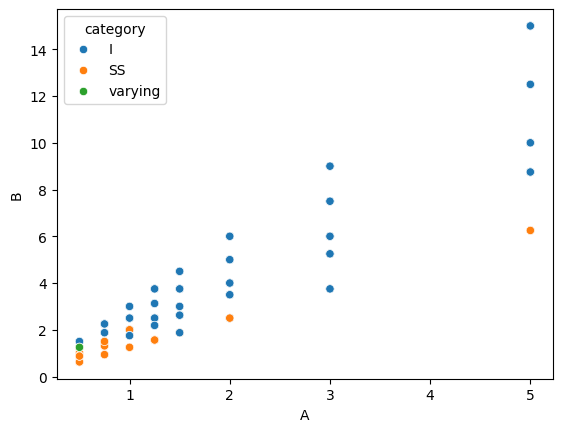

In [6]:
sns.scatterplot(
    df,
    x="A",
    y="B",
    hue="category",
)

In [ ]:
df_new['AB_ratio'] = df_new['B'] / df_new['A']
df_new['D_ratio'] = df_new['Dv'] / df_new['Du']

In [2]:
for x in ['A', 'B', 'Du', 'Dv']:
    grouped = df_new.groupby(x)
    for _, df_group in grouped:
        print(f"{x}={df_group[x].iloc[0]}")
        print(df_group.value_counts("category") / len(df_group))
        print()

NameError: name 'df_new' is not defined

In [5]:
# group_columns = ['A', 'B', 'Du', 'Dv']

# grouped = df.groupby(group_columns)

# # Identify groups where `category` has inconsistent values
# inconsistent_groups = grouped['category'].nunique() > 1

# # Extract and display the differing values for inconsistent groups
# if inconsistent_groups.any():
#     print("Inconsistent groups and their differing `category` values:")
#     for combination in inconsistent_groups[inconsistent_groups].index:
#         group = grouped.get_group(combination)
#         unique_categories = group['category'].unique()
#         print(f"Parameters {dict(zip(group_columns, combination))}: {unique_categories}")
# else:
#     print("The `category` column is consistent across all `random_seed` values for each parameter combination.")


In [6]:
# df_inc = filter_df(df, 0.5, 1.25, 1, 4)
# metrics_grid(df_inc, 0, var1="random_seed", var2="", metric="dev");

In [7]:
df_varying = df_new[df_new.category == 'varying']
n_varying = len(df_varying)

n_steady = n_varying
n_interesting = int(n_steady * percentages["interesting_behavior"] / percentages["steady_state"])

In [8]:
df_steady = df_new[df_new.category == "steady_state"].sample(n=n_steady)
df_interesting = df_new[df_new.category == "interesting_behavior"].sample(n=n_interesting)

sampling_centers = pd.concat([df_steady, df_interesting, df_varying])

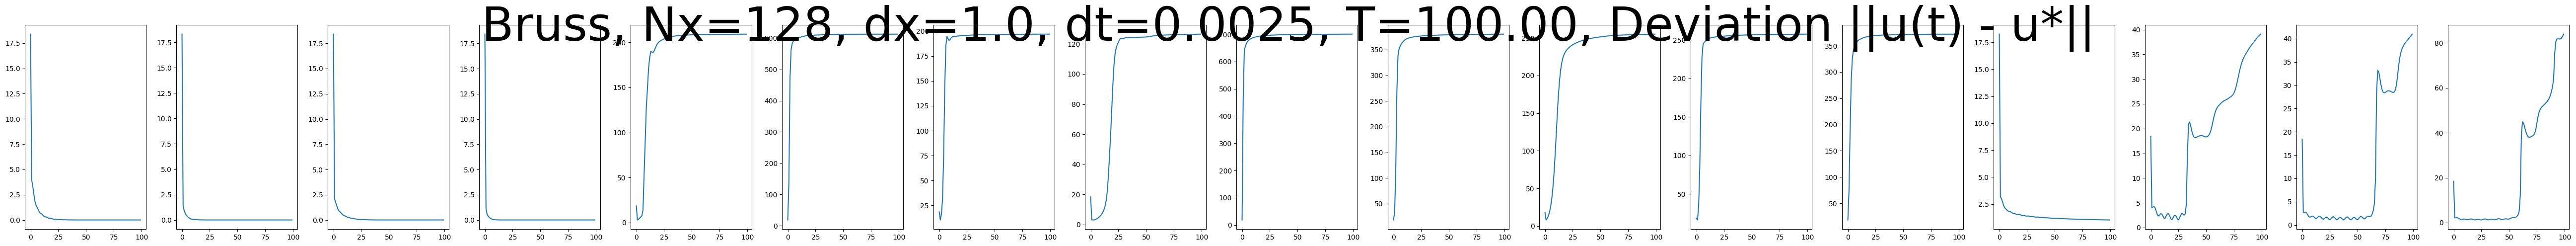

In [14]:
metrics_grid(sampling_centers, 0, var1="", var2="");

In [8]:
sampling_centers.to_csv("../data/sampling_centers.csv")

In [9]:
df["B_mult"] = df["B"] / df["A"]
df["D_mult"] = df["Dv"] / df["Du"]
px.scatter_3d(df, x="A", y="B_mult", z="D_mult", color="category")